In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs, plot_grid_anchors
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys
from models.bbox_preprocess import BboxesToAnchors

# Data Augmentation

In [3]:
class args:
    img_size = (256, 256)
    buffer_size = 64
    batch_size = 16
    epochs = 100

voc_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_train.tfrecord"
voc_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_val.tfrecord"
coco_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord"
coco_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord"
img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png'

translate = 0.2
rot = 40
scale = 0.35
kernel_size = 5
sigma = 1
augmentations = [
    RandomHorizontalFlip(), 
    RandomTranslate(translate=translate), 
    RandomRotate(rot=rot), 
    RandomZoom(scale=scale), 
    RandomMirror(), 
    AddNoise(), 
    RandomGamma(), 
    GaussianBlur(kernel_size=kernel_size, sigma=sigma)
]

In [4]:
ds_train = load_coco_dataset(args, coco_train_ds_path, augment_func = None, split = 'train')
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord...


In [5]:
tmvm = iter(ds_train)

In [6]:
kvsdk = next(tmvm)

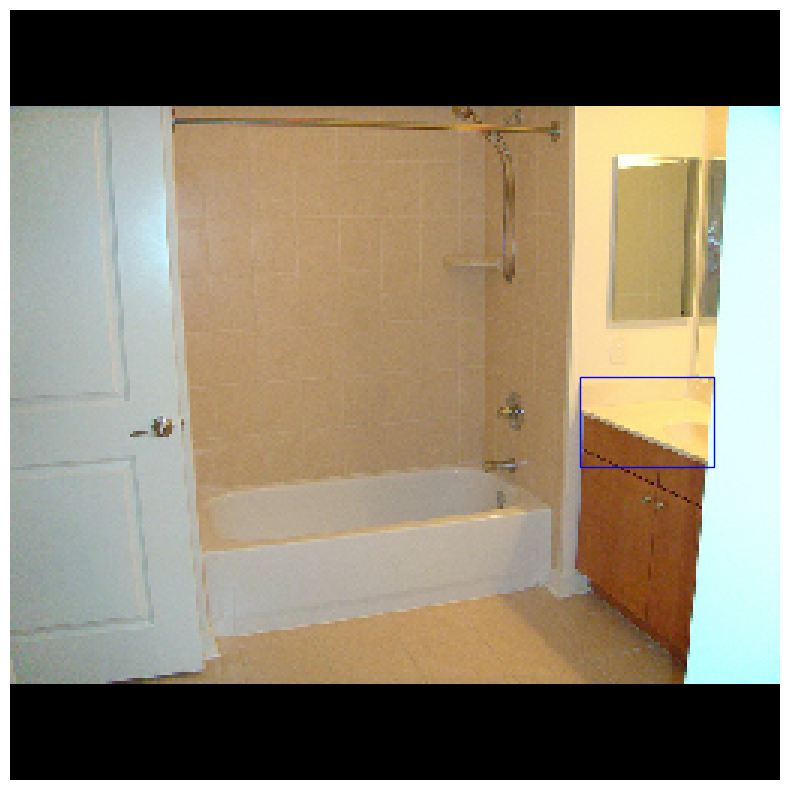

In [20]:
i = 1
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [15]:
grid_sizes = [8, 16, 32] # [8, 16, 32], [13, 26, 52]
NORMALIZED_ANCHORS = [[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
                      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
                      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]]
img_shape = img_to_test.shape
yolo_anchors = tf.constant([[(116, 90), (156, 198), (373, 326)],
                            [(30, 61), (62, 45), (59, 119)], 
                            [(10, 13), (16, 30), (33, 23)]], tf.float32) / 416.

In [16]:
setup_bboxes = BboxesToAnchors(grid_sizes, yolo_anchors, img_shape)

In [21]:
grid = setup_bboxes(its_bboxes[None, ...])

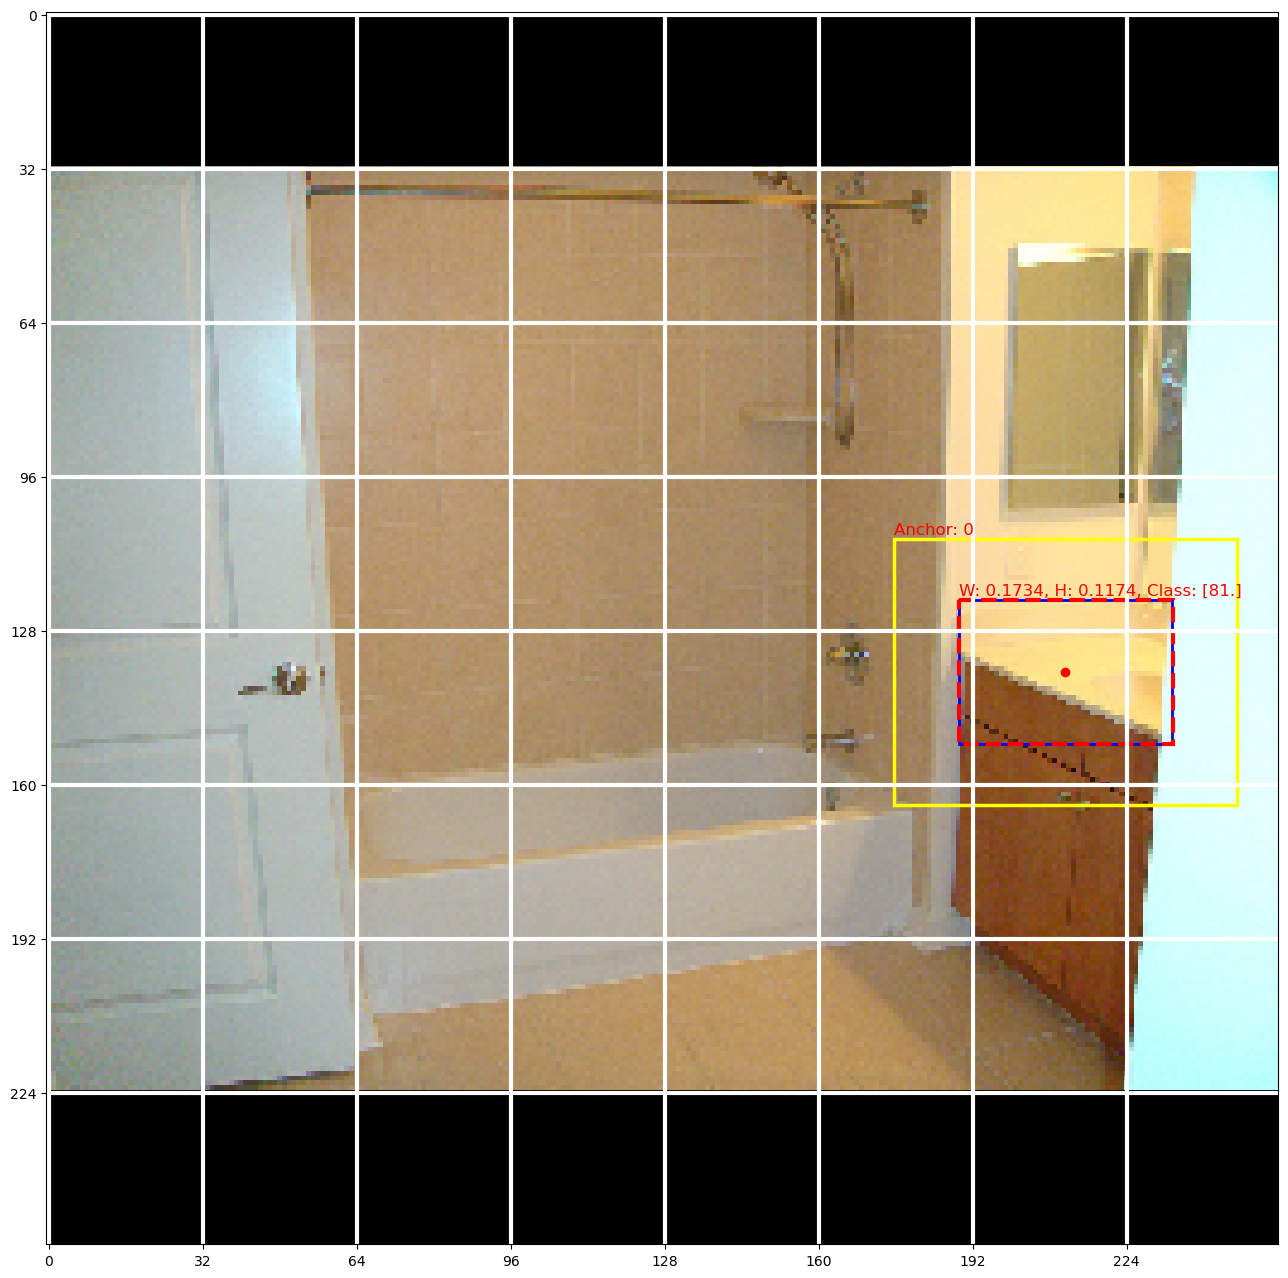

Total bboxes: 1, Total anchors: 1


In [22]:
c = 0
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (16, 16), yolo_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

In [23]:
def decode_model_outputs(pred, anchors, num_classes):

    """
    pred: [BS, Grid Size Y, Grid Size X, NUM_ANCHORS, 4 + 1 + NUM_CLASSES]
    anchors:
    num_classes:
    
    """

    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, confidence, class_probs = tf.split(pred, (2, 2, 1, NUM_CLASSES), axis=-1)

    box_xy           = tf.sigmoid(box_xy)
    confidence       = tf.sigmoid(confidence)
    class_probs      = tf.sigmoid(class_probs)
    pred_box_anchor  = tf.concat((box_xy, box_wh), axis=-1) 

    grid = tf.meshgrid(tf.range(grid_size[1], dtype=tf.float32), tf.range(grid_size[0], dtype=tf.float32)) # grid[x][y] == (y, x)
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + grid, tf.float32) / tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox     = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, confidence, class_probs, pred_box_anchor


def NMS(bboxes):

    pass


def LossFunction(y_true, y_pred):

    pass

# Make Sure Augmentations Work

In [24]:
augment_func = build_augmenter(aug_functions=augmentations, img_size=args.img_size)

In [29]:
dkl = tf.repeat(tf.Variable([[0.5]]), kvsdk[0].shape[0])
aug_bbox_input, obj_class_saved = tf.split(kvsdk[1], [4, 1], axis=-1)
test_aug = augment_func((kvsdk[0], aug_bbox_input, dkl))

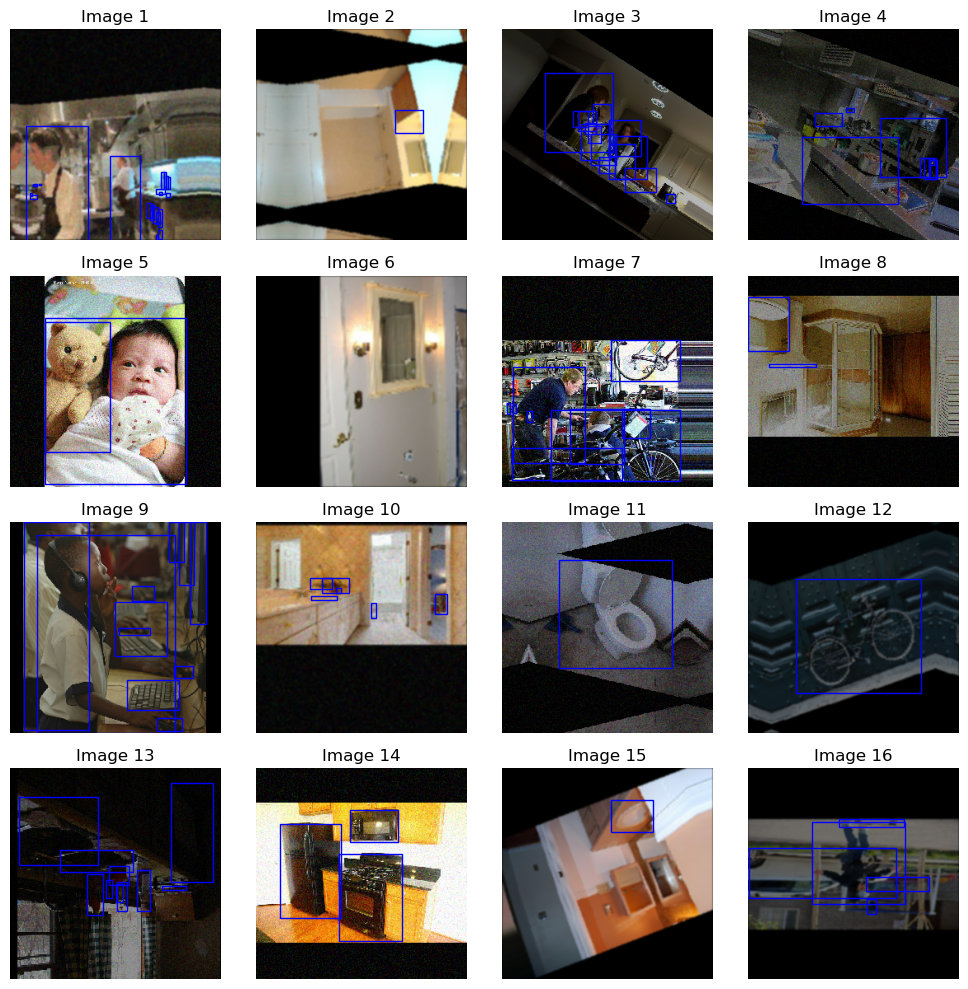

In [30]:
visualize_outputs(test_aug[0], test_aug[1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [35]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [69]:
augmenter.update(tf.constant(0.8))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.06491671]], dtype=float32)>


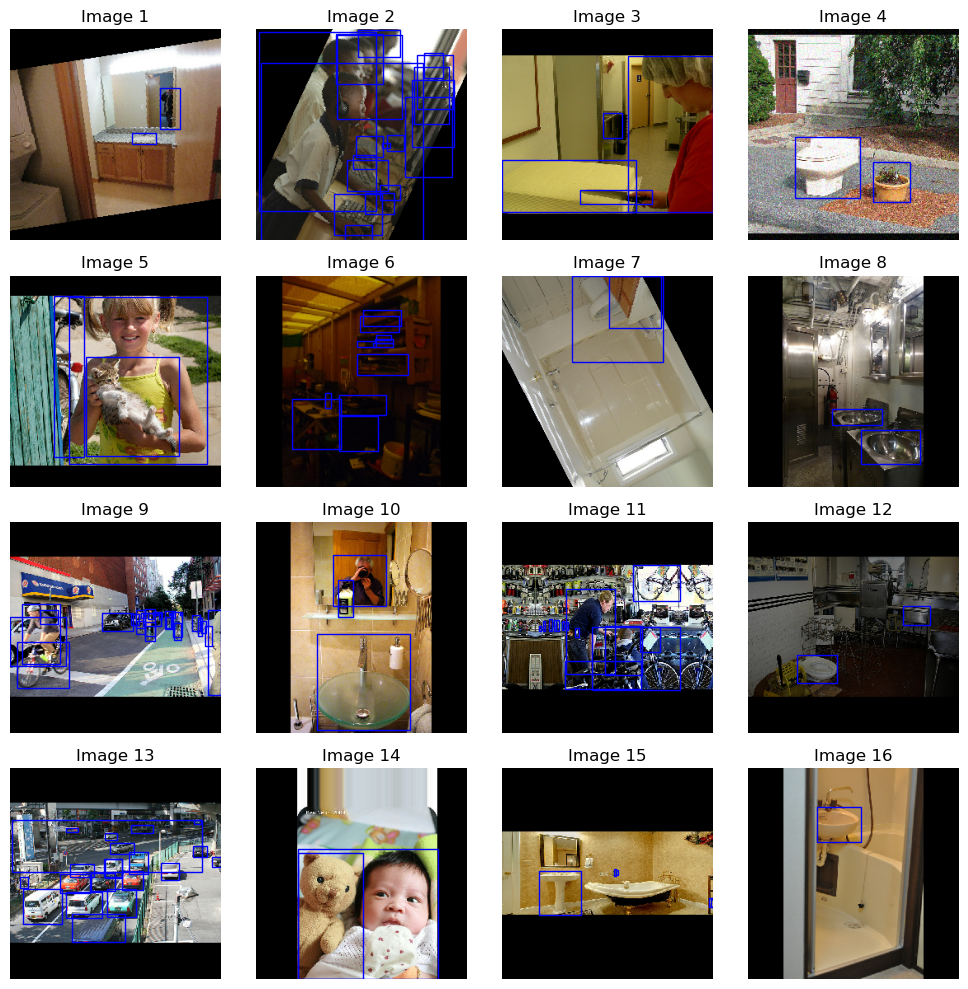

In [70]:
visualize_outputs(test_ada[0], test_ada[1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

# Model Architecture

In [447]:
def make_dummy_model(img_size):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN')(x)
    x = layers.Activation("relu", name='Act')(x)
    x = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same", name='Conv2')(x)
    x = layers.Flatten(name='Flatten')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(4, activation="sigmoid", name='Dense')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [708]:
class MyModel(tf.keras.Model):

    def __init__(self, 
                 img_size,
                 augment_func, # ada_p=0.5, ada_batch_p=0.0,
                 **kwargs):
               
        super(MyModel, self).__init__(**kwargs)

        self.img_size = img_size
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.model = make_dummy_model(img_size)
        self.ada = augment_func

    def compile(self, optimizer=None, metrics=[], *args, **kwargs):

        assert isinstance(metrics, list), "metrics input must be a list"
        self.train_step_counter.assign(0)
        self.optimizer = optimizer

        # Set up MyModel._metrics
        self.augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
        self.dice_coeff_tracker = tf.keras.metrics.Mean(name="dice_coeff_metric")  # <-------------------------- change this
        # self.loss_tracker = metrics[0] if len(metrics) == 1 else tf.keras.metrics.Mean(name="loss_metric") ###### Make it so metrics can be multiple items ######
        
        # Set up MyModel.compiled_metrics._metrics
        super(MyModel, self).compile(metrics=metrics, *args, **kwargs)

    @property
    def metrics(self):

        if self.compiled_metrics.built:
            return self.compiled_metrics._metrics[0] + [self.dice_coeff_tracker, self.augmentation_probability_tracker]
        else:
            return [self.dice_coeff_tracker, self.augmentation_probability_tracker]

    def train_step(self, ds_input):

        self.train_step_counter.assign_add(1)
        augmented_images, augmented_masks = self.ada(ds_input, training=True)
        
        with tf.GradientTape() as tape: # target tensor must be tf.float32

            predicted = self.model(augmented_images, training=True) # out: tf.float32 <- in: tf.float32
            loss = self.compiled_loss(augmented_masks, predicted) # out: tf.float32 <- in: tf.float32, tf.float32
            
        trainable_weights = self.model.trainable_weights
        model_grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(model_grads, trainable_weights))
        
        self.ada.update(loss)
        # self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(loss)
        self.dice_coeff_tracker.update_state(1-loss) # <-------------------------- change this
        self.augmentation_probability_tracker.update_state(self.ada.probability)
        
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, augment=False):

        augmented_images, augmented_masks = self.ada(inputs, training=training) if augment else inputs
        predicted = self.model(augmented_images, training=training)
        return augmented_images, augmented_masks, predicted

In [709]:
test_mymodel = MyModel(img_size=(128, 128), augment_func=None)

In [710]:
test_mymodel.compile(optimizer='adam', metrics=[tf.keras.metrics.MeanIoU(num_classes=4, name='meanIOU'), 'bce'], loss=myIOU)

In [717]:
test_mymodel.metrics_names

['meanIOU', 'bce', 'dice_coeff_metric', 'aug_probability']

In [712]:
for i in test_mymodel._metrics:
    print(i.name)

aug_probability
dice_coeff_metric


In [702]:
# test_mymodel.compiled_metrics.build(tf.constant([1.0, 2.0]), tf.constant([1.2, 2.3]))

In [713]:
vars(test_mymodel.compiled_metrics)

{'_output_names': None,
 '_user_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_user_weighted_metrics': None,
 '_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_weighted_metrics': None,
 '_built': False,
 '_from_serialized': False}

In [714]:
test_mymodel.compiled_metrics.update_state(tf.constant([1.0, 2.0]), tf.constant([1.5, 2.1]))

In [715]:
vars(test_mymodel.compiled_metrics)

{'_output_names': ['output_1'],
 '_user_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_user_weighted_metrics': None,
 '_metrics': [[<keras.metrics.MeanIoU at 0x233aed48a90>,
 '_weighted_metrics': [[None]],
 '_built': True,
 '_from_serialized': False,
 '_metrics_in_order': [<keras.metrics.MeanIoU at 0x233aed48a90>,
  <keras.metrics.MeanMetricWrapper at 0x233aed52a60>]}

In [716]:
test_mymodel.compiled_metrics._metrics[0][0].name

'meanIOU'

# Callback

In [ ]:
# Setup Callbacks

# Configuration

In [ ]:
# class Config(object):
#     """
#     Holds the configuration for anything you want it to.
#     To get the currently active config, call get_cfg().

#     To use, just do cfg.x instead of cfg['x'].
#     I made this because doing cfg['x'] all the time is dumb.
#     """

#     def __init__(self, config_dict):
#         for key, val in config_dict.items():
#             self.__setattr__(key, val)

#     def copy(self, new_config_dict={}):
#         """
#         Copies this config into a new config object, making
#         the changes given by new_config_dict.
#         """

#         ret = Config(vars(self))
        
#         for key, val in new_config_dict.items():
#             ret.__setattr__(key, val)

#         return ret

#     def replace(self, new_config_dict):
#         """
#         Copies new_config_dict into this config object.
#         Note: new_config_dict can also be a config object.
#         """
#         if isinstance(new_config_dict, Config):
#             new_config_dict = vars(new_config_dict)

#         for key, val in new_config_dict.items():
#             self.__setattr__(key, val)
    
#     def print(self):
#         for k, v in vars(self).items():
#             print(k, ' = ', v)

# Train

In [ ]:
def setupModel(args, dummy=False):
  
    params = {'anchors': args.anchors, 'classes': args.classes, 
            'projection_dim': args.projection_dim, 'num_heads': args.num_heads, 
            'patch_size_ratio': 1/args.patch_size_ratio, 'img_size': args.img_size}
  

    mymodel = make_dummy_model(params['img_size'])

    model_dir = 'weights/'

    if args.visualize_training == 1:

        sample_img = tf.keras.utils.load_img(os.path.join(os.getcwd(), 'img.png'))
        input_arr = tf.keras.utils.img_to_array(sample_img, data_format='channels_last')
        input_arr = tf.image.resize(input_arr, size=args.img_size, method='nearest')
        example_img = tf.convert_to_tensor(input_arr / 255)

        weights_path = os.path.join(os.getcwd(), model_dir, "weights_epoch_{epoch}")
        print(f"Storing weights at {weights_path}")

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1), DisplayCallback(example_img)]
    else: 

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(), "weights_epoch_{epoch}"), 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1)]

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]

        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-06)

    return mymodel, customLoss, callbacks_list, optimizer

# Extra

In [ ]:
# vsddsv = tf.constant([[4, 5, 6, 7], 
#                       [0, 1, 2, 0],
#                       [0, 1, 2, 1]])
# ppppp = tf.constant([0, 1, 2])

# num_instances_we_use_grid = tf.math.equal(vsddsv[1:, 0:-1], ppppp)
# num_anchors_seen_in_grid = tf.where(tf.reduce_all(num_instances_we_use_grid, axis=-1))
# tf.shape(num_anchors_seen_in_grid)[0]

In [ ]:
# class BboxesToAnchors(Converter):

#     def __init__(self, 
#                  grid_sizes = [13, 26, 52], # [13, 26, 52] 
#                  anchors = [[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
#                             [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
#                             [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]],
#                  image_shape = None,
#                  **kwargs):

#         super(BboxesToAnchors, self).__init__(**kwargs)
#         self.grid_sizes = grid_sizes
#         self.anchors = anchors
#         self.image_shape = image_shape

#     def iou_bbox_v_anchors(self, boxes1, anchors):

#         box1width, box1height = tf.split(boxes1, 2, axis=-1) # [bs, N, 1], [bs, N, 1]

#         box2width, box2height = tf.split(anchors, 2, axis=-1) # [num_anchors, 1], [num_anchors, 1]
#         box2width_fix = tf.transpose(box2width)[None, ...] # [num_anchors, 1] -> [1, num_anchors] -> [1, 1, num_anchors]
#         box2height_fix = tf.transpose(box2height)[None, ...] # [num_anchors, 1] -> [1, num_anchors] -> [1, 1, num_anchors]

#         min_width = tf.minimum(box1width, box2width_fix) # [bs, N, num_anchors]
#         min_height = tf.minimum(box1height, box2height_fix) # [bs, N, num_anchors]

#         intersection = min_width * min_height # [bs, N, num_anchors]

#         box1_area = box1width * box1height # [bs, N, 1]
#         box2_area = box2width * box2height # [num_anchors, 1]

#         union = box1_area + tf.transpose(box2_area)[None, ...] - intersection
#         return intersection / union # [bs, N, num_anchors] where bs_i, N_j, num_anchors_k is the IOU between boxes1[bs_i, N_j, ...] and anchors[num_anchors_k, ...]

#     def get_original_indices(self, indices):

#         """
#         Get the indices of original data

#         Ex:
#         indices = tf.constant([[9, 1, 2, 5],  #0 <---A*
#                                [9, 2, 1, 3],  #1 <---B*
#                                [9, 1, 2, 2],  #2      *
#                                [9, 2, 1, 3],  #3 <---B
#                                [9, 1, 2, 1],  #4 <---C*
#                                [9, 1, 2, 1],  #5 <---C
#                                [9, 1, 2, 5],  #6 <---A
#                                [9, 2, 1, 3]]) #7 <---B
        
#         Will give [0, 1, 2, 4] where there are *
#         """

#         # Make upper triangule
#         Bs_x_N = tf.shape(indices)[0]
#         a      = tf.range(Bs_x_N)[tf.newaxis, :]
#         b      = tf.range(Bs_x_N)[:, tf.newaxis]
#         uppT   = tf.cast(tf.greater(a, b), tf.float32)

#         # Make broadcastable
#         indices1 = indices[None, ...]
#         indices2 = indices[:, None, :]

#         # Get the original-copy pairs
#         elem_wise_comparison       = tf.math.equal(indices1, indices2) # [1, BS*N, 4], [BS*N, 1, 4] -> [BS*N, BS*N, 4]
#         comparison_btwn_each_item  = tf.reduce_all(elem_wise_comparison, axis=-1) # [BS*N, BS*N]
#         get_where_duplicates_occur = tf.cast(comparison_btwn_each_item, tf.float32) * uppT # [BS*N, BS*N] Why multiply by upper traingle? Because the diagonal is always going to be True and to eliminate symmetry
#         original_copy_pairs        = tf.cast(tf.where(get_where_duplicates_occur), tf.int32)
#         tf.print(original_copy_pairs)

#         # Get only the originals, remember that a copy can also be an original e.g [0, 1] [1, 2] this means 0 == 1 == 2, but we only need 0
#         unique_originals = tf.unique(original_copy_pairs[..., 0])[0]
#         unique_copies    = tf.unique(original_copy_pairs[..., 1])[0]
#         original         = tf.sets.difference(unique_originals[None, ...], unique_copies[None, ...]).values

#         # From the original data, get the indices of non duplicates
#         originals = tf.gather(get_where_duplicates_occur, original)
#         copies    = tf.cast(tf.where(originals)[..., 1], tf.int32)
#         all_idxs  = tf.range(Bs_x_N)

#         # Get output
#         non_duplicates = tf.sets.difference(all_idxs[None, ...], copies[None, ...], aminusb=True).values
#         return non_duplicates


#     def bboxes_to_grid(self, bboxes, grid_size, anchors, num_anchors, scale):
#         """
#         Inputs:
#             bboxes: shape - [BS, N, 4] - y, x, h, w
#             grid_size: int determining the grid size
#             anchors: respective anchors to use
#             num_anchors: number of anchors for the given grid size (aka num anchors for each scale)
#             scale: respective scale for the given grid size
#         Output:
#             anchor_targets
#         """
#         bs         = tf.shape(bboxes)[0]
#         y_true_out = tf.zeros((bs, grid_size, grid_size, num_anchors, 6)) # [BS, grid_size, grid_size, num_anchors, 6]
#         bboxes     = self.yxyx_to_yxhw(bboxes)
#         mask       = self.mask(bboxes)[..., 0][..., None] # [BS, N, 1]
#         y, x, h, w = tf.split(bboxes, 4, axis=-1) # [BS, N, 1], [BS, N, 1], [BS, N, 1], [BS, N, 1] with values between 0 and 1

#         # Get the cell bbox belongs to and the coordinates it would lie inside the cell
#         grid_y, grid_x  = tf.cast(scale * y, tf.int32), tf.cast(scale * x, tf.int32)  # [BS, N, 1], [BS, N, 1] where 1 is the respective index of the cell y, x fall into 
#         y_inside_cell   = scale * y - tf.cast(grid_y, dtype=y.dtype)
#         x_inside_cell   = scale * x - tf.cast(grid_x, dtype=x.dtype)
#         bbox_coord_grid = tf.concat([y_inside_cell, x_inside_cell, h, w], axis=-1) # [BS, N, 4]

#         # Get IOU between bboxes and anchors
#         wh                   = tf.concat([w, h], axis=-1) # get w, h as apparently that is what anchors are
#         iou_anchors          = self.iou_bbox_v_anchors(wh, anchors) # [BS, N, num_anchors] where (bs_i, N_j) and num_anchors_k is the IOU between wh[bs_i, N_j] and anchors[num_anchors_k]
#         anchors_sorted_indxs = tf.argsort(iou_anchors, direction='DESCENDING', axis=-1) # [BS, N, num_anchors] get anchor indices in order of IOU

#         # Sort the anchors for each box and sort the bboxes so that the one with larger max IOU to ANY anchor box goes first
#         iou_sorted        = tf.gather(iou_anchors, anchors_sorted_indxs, axis=-1, batch_dims=-1) # [BS, N, num_anchors] sort the anchors for each box
#         iou_optimal_value = iou_sorted[..., 0] # [BS, N] get the VALUE of the max IOU btwn bbox and optimal anchor
#         importance        = tf.argsort(iou_optimal_value, direction='DESCENDING', axis=-1) # [BS, N]

#         # Sort optimal anchors, if for a cell there 1> anchors needed, whenever tf.tensor_scatter_nd_update updates values at a given index, it keeps the last one a.k.a. the one with higher IOU
#         optimal_anchors = anchors_sorted_indxs[..., 0][..., None] # [BS, N, 1] get the INDEX of the optimal anchor 
#         optimal_anchors = tf.gather(optimal_anchors, importance, axis=1, batch_dims=-1) # [BS, N, 1] sort so bboxes with higher first IOU to ANY anchor box go first
#         anchors_sorted_indxs = tf.gather(anchors_sorted_indxs, importance, axis=1, batch_dims=-1) # [BS, N, num_anchors] sort so bboxes with higher first IOU to ANY anchor box go first

#         # Sort following to keep consistency
#         grid_y          = tf.gather(grid_y, importance, axis=1, batch_dims=-1) # [BS, N, 1]
#         grid_x          = tf.gather(grid_x, importance, axis=1, batch_dims=-1) # [BS, N, 1]
#         mask            = tf.gather(mask, importance, axis=1, batch_dims=-1) # [BS, N, 1]
#         bbox_coord_grid = tf.gather(bbox_coord_grid, importance, axis=1, batch_dims=-1) # [BS, N, 4]
#         iou_optimal_val = tf.gather(iou_optimal_value[..., None], importance, axis=1, batch_dims=-1) # REALLY ONLY FOR DEBUGGUGING PURPOSES

#         # Make indices
#         indices   = tf.concat([grid_y, grid_x, optimal_anchors], axis=-1) * tf.cast(mask, tf.int32) # [BS, N, 3]
#         indices   = tf.reshape(indices, shape=[-1, 3]) # [BS * N, 3]
#         BS_x_N    = tf.range(tf.shape(indices)[0])[..., None] # [BS * N, 1]
#         batch_idx = tf.math.mod(BS_x_N, bs) # [BS * N, 1] of values 0 to BS-1. This is to keep track of the batch index after tf.reshape 
#         indices   = tf.cast(tf.concat([batch_idx, indices], axis=-1), tf.int32) # [BS * N, 4]
#         indices   = indices * tf.reshape(tf.cast(mask, tf.int32), [-1, 1]) # [BS * N, 4]

#         # Make updates
#         probability = tf.ones_like(optimal_anchors, dtype=bbox_coord_grid.dtype) # [BS, N, 1]
#         obj_class   = tf.random.uniform(shape=optimal_anchors.shape, minval=0, maxval=100, dtype=bbox_coord_grid.dtype) # # [BS, N, 1] <-------------------------------------------------------------------------
#         updates     = tf.concat([bbox_coord_grid, probability, obj_class], axis=-1) * mask # [BS, N, 6]
#         updates     = tf.reshape(updates, shape=[-1, 6]) # [BS * N, 6]

#         # Filter out [0, 0, 0, 0]'s from indices; however in the case that in batch 0, gridy 0, gridx 0, anchor 0 is needed for a bbox, we filter those that don't have bboxes
#         final_updates = tf.boolean_mask(updates, tf.cast(tf.math.count_nonzero(updates, axis=-1), tf.bool)) # Remove those who don't have bboxes
#         final_indices = tf.boolean_mask(indices, tf.cast(tf.math.count_nonzero(updates, axis=-1), tf.bool)) # Remove those who don't have bboxes

#         # Get non duplicates
#         true_indices  = self.get_original_indices(final_indices)
#         tf.print(true_indices)
        
#         final_indices = tf.gather(final_indices, true_indices)
#         final_updates = tf.gather(final_updates, true_indices)

#         ##################################################### TODO #####################################################
#         # FOR DUPLICATES GET THE NEXT ANCHOR IF IOU > 0.5
#         anchors_sorted_indxs_next  = tf.roll(anchors_sorted_indxs, -1, axis=-1)[..., 0][..., None]
#         ################################################################################################################    

#         # Get output
#         anchor_targets = tf.tensor_scatter_nd_update(y_true_out, final_indices, final_updates) # y_true_out[batch][y][x][anchor] = (y, x, h, w, 1, class)
#         return anchor_targets
    
#     def call(self, bboxes):

#         a = self.bboxes_to_grid(bboxes, self.grid_sizes[0], self.anchors[0], num_anchors=3, scale=self.grid_sizes[0])
#         b = self.bboxes_to_grid(bboxes, self.grid_sizes[1], self.anchors[1], num_anchors=3, scale=self.grid_sizes[1])
#         c = self.bboxes_to_grid(bboxes, self.grid_sizes[2], self.anchors[2], num_anchors=3, scale=self.grid_sizes[2])
#         return a, b, c

In [ ]:
# batch_boxes1 = tf.random.uniform(shape=(1, 2, 4))
# print(batch_boxes1)
# batch_boxes2 = anchors[:3]
# batch_boxes1[..., 2:][..., ::-1]
# print("out ---------------------------------------------")
# out = iou_width_height(batch_boxes1[..., 2:][..., ::-1], batch_boxes2)
# print(out)
# print("sortedd ---------------------------------------------")
# sortedd = tf.argsort(out, direction='DESCENDING', axis=-1)
# print(sortedd)
# print("iou_sorted ---------------------------------------------")
# iou_sorted = tf.gather(out, sortedd, axis=-1, batch_dims=-1)
# print(iou_sorted)
# print("opt ---------------------------------------------")
# opt = tf.argmax(out, axis=-1)[..., None]
# print(opt)
# print("val_of_optimal_iou ---------------------------------------------")
# val_of_optimal_iou = iou_sorted[..., 0]
# print(val_of_optimal_iou)
# print("important_sort ---------------------------------------------")
# important_sort = tf.argsort(val_of_optimal_iou, direction='DESCENDING', axis=-1)
# print(important_sort)
# print("sor ---------------------------------------------")
# sor = tf.gather(iou_sorted, important_sort, axis=1, batch_dims=-1)
# print(sor)
# print("sorted_opt ---------------------------------------------")
# sorted_opt = tf.gather(opt, important_sort, axis=1, batch_dims=-1)
# print(sorted_opt)

In [ ]:
    # original = tf.TensorArray(tf.int32, size=1, dynamic_size=True)
    # copy = tf.TensorArray(tf.int32, size=1, dynamic_size=True)
    # j = tf.Variable(0, trainable=False)
    # original.write(index = tf.convert_to_tensor(j), value=indx[0][0]).mark_used() 
    # copy.write(index = tf.convert_to_tensor(j), value=indx[0][1]).mark_used()
    # for i in range(len(indx)):
    #     row = indx[i]
    #     if row[0] not in original.stack():
    #         if row[1] not in copy.stack():
    #             j.assign_add(1)
    #             original.write(index = tf.convert_to_tensor(j), value=row[0]).mark_used() 
    #     copy.write(index = tf.convert_to_tensor(j), value=row[1]).mark_used()

In [ ]:
# class Augmentations(object):

#     def __init__(self, aug_functions):

#         if not isinstance(aug_functions, list):
#             aug_functions = [aug_functions]
#         self.aug_functions = aug_functions

#     def build(self, img_size):

#         if len(img_size) == 2:
#             self.img_shape = img_size + (3,)
    
#         if len(img_size) == 3:
#             self.img_shape = img_size

#         input_img = layers.Input(shape=self.img_shape)
#         input_bboxes = layers.Input(shape=(None, 4))
#         x = (input_img, input_bboxes)
#         for func in self.aug_functions:
#             x = func(x)

#         self.augment_model = tf.keras.Model([input_img, input_bboxes], x, name='obj_det_data_augmentation_function')

#     def visualize_outputs(self, imgs, bboxes, scale, figsize, linewidth, color):

#         num_images = len(imgs)
#         titles = ['Image {}'.format(i+1) for i in range(num_images)]
        
#         rows = np.floor(np.sqrt(num_images))
#         cols = np.ceil(num_images / rows)

#         fig, axes = plt.subplots(int(rows), int(cols), figsize=figsize)
#         for i, ax in enumerate(axes.flat):
#             if i < num_images:
#                 image = imgs[i]
#                 boxes = bboxes[i] * scale
#                 ax.imshow(np.array(image))

#                 for box in boxes:
#                     y1, x1, y2, x2 = box
#                     w, h = x2 - x1, y2 - y1
#                     patch = plt.Rectangle(
#                         [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
#                     ax.add_patch(patch)
                    
#                 ax.axis('off')
#                 ax.set_title(titles[i])
#             else:
#                 ax.axis('off')
#         plt.tight_layout()
#         plt.show()

#     def __call__(self, inputs):
        
#         scale = tf.constant(list(self.img_shape[0:2] * 2), dtype=tf.float32)

#         start = time.time()
#         out_imgs, out_bboxes = self.augment_model(inputs)
#         end = time.time()
#         print(f'Data augmentation took {end - start} seconds')
        
#         print('Displaying Images...')
#         self.visualize_outputs(out_imgs, out_bboxes, scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [ ]:
# i = -3
# img_to_resize = kvsdk[0][i]
# its_bboxes = kvsdk[1][i]
# visualize_boxes(img_to_resize,its_bboxes*tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(5, 5), linewidth=1, color=[0, 0, 1])

# new_h = 239
# new_w = 312
# scale = tf.constant([new_h, new_w, new_h, new_w], dtype=tf.float32)
# img_to_resize_out = tf.image.resize_with_pad(img_to_resize, target_height = new_h, target_width = new_w)


# img_h = img_to_resize.shape[0]
# img_w = img_to_resize.shape[1]

# # Calcualte the size of the new image that will be placed at the center of the "canvas" of height new_h and width new_w
# h = img_h * tf.math.minimum(new_w/img_w, new_h/img_h)
# w = img_w * tf.math.minimum(new_w/img_w, new_h/img_h)
# ratio = tf.cast(tf.concat([h, w, h, w], axis=0), dtype=its_bboxes.dtype) / scale

# # Calculate how much padding is needed
# lower_h = (new_h-h)//2
# upper_h = (new_h-h)//2 + h
# lower_w = (new_w-w)//2
# upper_w = (new_w-w)//2 + w

# # Calculate the percentage that should be added to shift the bboxes correctly due to the padding
# add_to_bboxes_h = lower_h/h
# add_to_bboxes_w = lower_w/w

# new_bboxes = (its_bboxes + tf.cast(tf.concat([add_to_bboxes_h, add_to_bboxes_w, add_to_bboxes_h, add_to_bboxes_w], axis=0), its_bboxes.dtype)) * ratio

# visualize_boxes(img_to_resize_out, new_bboxes*scale, figsize=(5, 5), linewidth=1, color=[0, 0, 1])